Разобьём текст для его более легкого чтения и сохраним в формате json

In [1]:
import json
from os import listdir
from os.path import isfile, join

path = r"C:\Users\Home\Downloads\Telegram Desktop\src_files"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
path_f = path + "\\" + onlyfiles[0]
with open(path_f, 'r', encoding="utf-8", errors='ignore') as file:
    data = json.loads(file.read())
    with open("sample.json", "w") as outfile:
        json.dump(data, outfile, ensure_ascii=False)


Пройдёмся по файлу и выделим наиболее важные для нас признаки, сделаем из них новый датасет.
(text – текст обращения пользователя,
district_name – наименование округа,
target – идентификатор категории,
target_name – наименование категории.)

In [2]:
import json
import os
import pandas
from tqdm import tqdm

raw_datadir = r"C:\Users\Home\Downloads\Telegram Desktop\src_files"
files_list = os.listdir(raw_datadir)
df = []
for f in tqdm(files_list):
    try:
        with open(f'{raw_datadir}/{f}', encoding='UTF-8') as fl:
            raw = json.load(fl)
        data_structure = {}
        # parse text
        preproc_text = ''
        for i, w in enumerate(raw['feed']):
            if w['widget'] == 'public.petition':
                body_text = raw['feed'][i]['payload']['body']
                raw_text = " ".join([t['text'] for t in body_text])
                preproc_text = raw_text.strip()
                break  # если нашли нужный виджет, то смысла идти по циклу больше нет

        data_structure['text'] = preproc_text
        data_structure['district_name'] = raw['district_name']
        data_structure['target'] = raw['reason']['category']['id']
        data_structure['target_name'] = raw['reason']['category']['name']
        df.append(data_structure)
    except Exception:
        print('Что-то пошло не так :(')
        print('file name:', f)
        continue  # продолжаем цикл для обработки остальных файлов, а с этим будем разбираться отдельно, возможно он какой-то некорректный!?

df = pandas.DataFrame(df)
df.to_csv("dataframe.csv")

100%|██████████| 59889/59889 [00:57<00:00, 1046.87it/s]


Прочтём файл и посмотрим на его содержимое

In [3]:
import pandas as pd
data = pd.read_csv('dataframe.csv')
data

,Unnamed: 0,text,district_name,target,target_name
0,0,"1й подъезд, 5 этаж. В коридоре над XXXX виси...",Приморский,10,Содержание МКД
1,1,Маленькмй лифт изрисован внутри.,Колпинский,10,Содержание МКД
2,2,реклама на светофоре,Красносельский,3,Благоустройство
3,3,"1й подъезд, 5 этаж, квартирный холл. Рааботник...",Приморский,10,Содержание МКД
4,4,незаконная решетка на фасаде,Адмиралтейский,23,Нарушение правил пользования общим имуществом
...,...,...,...,...,...
59884,59884,Систематическое блокирование парковки крупнога...,Выборгский,2,Благоустройство
59885,59885,"Ул. Маршала Захарова, д. 14/4.высокая точка за...",Красносельский,2,Благоустройство
59886,59886,"люк выдавило, гранитное мощение вокруг люка вы...",Центральный,61,Повреждения или неисправность элементов улично...
59887,59887,Повреждён асфальт вокруг люка,Фрунзенский,61,Повреждения или неисправность элементов улично...


Перед тем, как приступить к подготовке моделей, необходимо повнимательней посмотреть на имеющиеся данные. В первую очередь, необходимо проверить, какие уникальные значения принимают все признаки за исключением текста обращения. Текст требует отдельной обработки: очистки от стоп-слов, пунктуации, приведению всех слов к начальной форме.

In [4]:
data.district_name.value_counts()

Невский              8100
Выборгский           6301
Калининский          5209
Центральный          4959
Московский           4545
Кировский            4090
Приморский           3785
Красносельский       3624
Красногвардейский    3308
Фрунзенский          3150
Адмиралтейский       2990
Пушкинский           2667
Василеостровский     2496
Петроградский        1913
Колпинский           1140
Петродворцовый       1001
Курортный             415
Кронштадтский         196
Name: district_name, dtype: int64

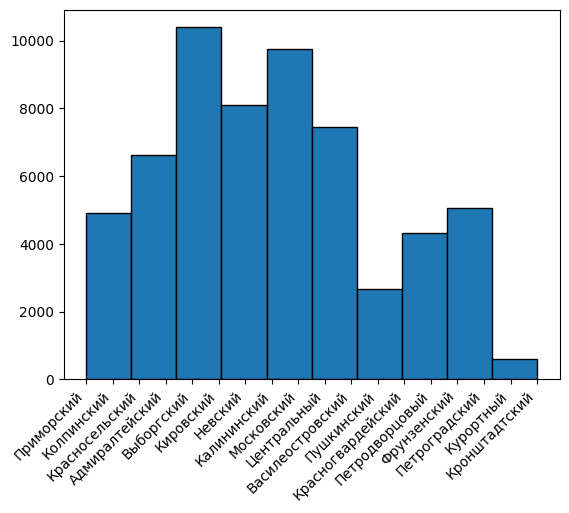

In [5]:
import matplotlib.pyplot as plt
dat1 = data['district_name']

#create frequency histogram
fig = plt.figure()
ax = fig.add_subplot (111)
ax.hist (dat1, edgecolor='black') 
plt.xticks(rotation = 45, horizontalalignment = 'right')
plt.show()

Как видим все наименования округов уникальны, опечаток нет.

In [6]:
data.target_name.value_counts()

Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элементов уличной инфраструктуры                       1164
Кровля                                                                                825
Водоснабжение                                                                         809
Состояние рекламных или информационных конструкций                                    673
Санитарное состояние                                                                  434
Центральное отопление                                                                 284
Подвалы   

Как видим, самая часто используемая категория обращения связана с благоустройством. Также видим, что в наборе данных имеется дисбаланс классов.

Теперь займёмся текстом.

План предварительной обработки текста:

подготовить список стоп-слов, пунктуации, спецсимволов и цифр – всё это будем удалять;

собрать текстовый корпус, в котором не будет стоп-слов, пунктуации, спецсимволов и цифр, а также все тексты привести к нижнему регистру;

провести лемматизацию для исключения различных форм одного и того же слова;

выделить токены – слова, встречающиеся в корпусе и приведённые к изначальной форме (лемматизированные слова).

In [7]:
import nltk
import matplotlib.pyplot as plt
import re
 
from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
 
nltk.download('stopwords')

stop_words_rus = set(stopwords.words('russian'))
stop_words_eng = set(stopwords.words('english'))  # бывают также английские слова попадаются на практике, включим стоп-слова для чистоты целевого датасет
 
# punctuation == '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
numbers = [i for i in range(10)]
numbers = list(map(str, numbers))
# numbers == ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

mysteam = Mystem()  # инициализируем для последующего использования при лемматизации

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(raw_text):
   """
   Метод для предобработки исходного текста
   """
   tokens = mysteam.lemmatize(raw_text.lower())  # лемматизация и приведение к нижнему регистру
 
   """
   удаление стоп-слов и всяких ненужных символов
   регулярочка помогает заменить токены типа "1й", которые встречаются в тексте на *, которые потом просто удаляем из списка
   """
   text = [re.sub('[0-9][а-я]', '*', token) for token in tokens if (token.strip() not in stop_words_rus) & \
                             (token.strip() not in stop_words_eng) & \
                             (token.strip() not in punctuation) & \
                             (token.strip() not in numbers) & \
                             (token != ' ')]
   if '*' in text:
       text.remove('*')
  
   return ' '.join(text)

In [9]:
text = preprocess_text(data.text[0])
text
'подъезд этаж коридор висеть какой-то провод возможно напряжение председатель тсж ленинградский вечер отказываться принимать заявка устранение полгода'

'подъезд этаж коридор висеть какой-то провод возможно напряжение председатель тсж ленинградский вечер отказываться принимать заявка устранение полгода'

На одном примере работает корректно, соберём далее корпус из очищенных/предобработанных текстов для последующего перевода текста в числовой вид с помощью алгоритма векторизации.

In [10]:
corpus = []
for row in tqdm(data.iterrows()):
   text = preprocess_text(row[1]['text'])
   corpus.append(text)

1886it [1:09:26,  2.21s/it]


KeyboardInterrupt: 